In [1]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from transformers import AutoTokenizer, AutoConfig
from datasets import load_dataset
from transformer_encoder_from_scratch.transformer_encoder_from_scratch import TransformerEncoderFromScratchForSequenceClassification
from transformer_encoder_from_scratch.train import train, test

### Dataset

In [2]:
ds = load_dataset('emotion')
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
model_chckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chckpt)

/home/tgniazdo/miniconda3/envs/ner/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def tokenize_batch(batch, tokenizer=tokenizer):
    return tokenizer(batch['text'], padding=True, truncation=True)

ds = ds.map(tokenize_batch, batched=True, batch_size=None)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [5]:
ds.set_format('pytorch')

In [6]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

In [7]:
train_dl = DataLoader(tuple(zip(train_ds['input_ids'], train_ds['label'])), batch_size=32)
val_dl = DataLoader(tuple(zip(val_ds['input_ids'], val_ds['label'])), batch_size=32)
test_dl = DataLoader(tuple(zip(test_ds['input_ids'], test_ds['label'])), batch_size=32)

In [8]:
config = AutoConfig.from_pretrained(model_chckpt)
config.num_labels = 6
model = TransformerEncoderFromScratchForSequenceClassification(config).to('cuda')

  0%|          | 0/20 [00:00<?, ?it/s]

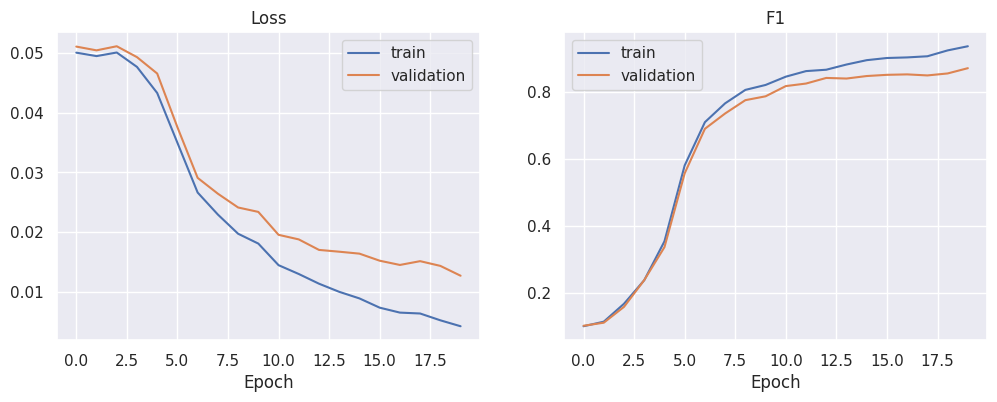

In [9]:
num_epochs = 20
learning_rate = 2e-5
optimizer = Adam(model.parameters(), lr=learning_rate)


model = train(
    model=model,
    optimizer=optimizer,
    loss_fn=CrossEntropyLoss(),
    epochs=num_epochs,
    train_dl=train_dl,
    val_dl=val_dl,
    patience=num_epochs,
    print_metrics=True,
    device='cuda',
    best_model_path='transformer_from_scratch_emotions.pth'
)

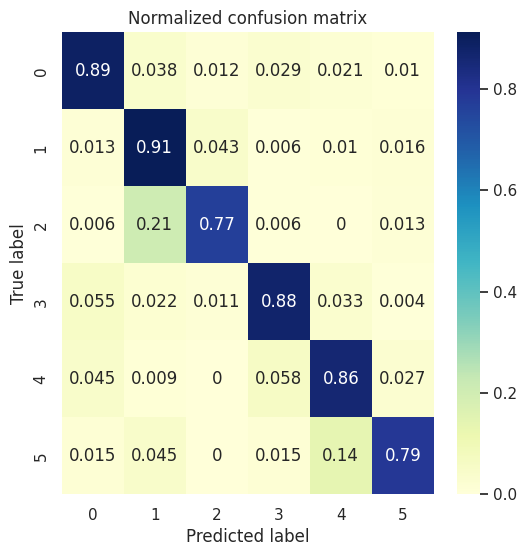

{'0': {'precision': 0.9349005424954792,
  'recall': 0.8898450946643718,
  'f1-score': 0.9118165784832452,
  'support': 581.0},
 '1': {'precision': 0.9057142857142857,
  'recall': 0.9122302158273381,
  'f1-score': 0.9089605734767026,
  'support': 695.0},
 '2': {'precision': 0.7530864197530864,
  'recall': 0.7672955974842768,
  'f1-score': 0.7601246105919003,
  'support': 159.0},
 '3': {'precision': 0.8700361010830325,
  'recall': 0.8763636363636363,
  'f1-score': 0.8731884057971014,
  'support': 275.0},
 '4': {'precision': 0.8391304347826087,
  'recall': 0.8616071428571429,
  'f1-score': 0.8502202643171806,
  'support': 224.0},
 '5': {'precision': 0.6666666666666666,
  'recall': 0.7878787878787878,
  'f1-score': 0.7222222222222222,
  'support': 66.0},
 'accuracy': 0.8795,
 'macro avg': {'precision': 0.8282557417491933,
  'recall': 0.8492034125125923,
  'f1-score': 0.8377554424813921,
  'support': 2000.0},
 'weighted avg': {'precision': 0.8818072648455906,
  'recall': 0.8795,
  'f1-score

In [10]:
test(
    model=model,
    dataloader=test_dl,
    device='cuda'
)